In [1]:
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import seaborn as sns
from typing import Iterable

sns.set_theme()

In [2]:
PROJECT_ROOT = Path.cwd().parent.resolve()
BENCHMARKS_DIR = PROJECT_ROOT/"benchmarks"

In [3]:
def load_data(model_name: str, task_name: str) -> DataFrame:
    path_to_csv = BENCHMARKS_DIR/model_name/f"{task_name}.csv"
    df = pd.read_csv(path_to_csv)
    return df

def plot_auc_distributions(model_names: Iterable[str], task_name: str) -> Figure:
    benchmark_results_per_model = {
        model_name: load_data(model_name, task_name) for model_name in model_names
    }
    mean_aucs_per_model = {
        model_name: df["mean_auc"] for model_name, df in benchmark_results_per_model.items()
    }

    fig, ax = plt.subplots()

    ax.set_title(task_name)
    ax.boxplot(x=mean_aucs_per_model.values(), labels=mean_aucs_per_model.keys(), showmeans=True, meanline=True)
    ax.plot(range(1, 1+len(mean_aucs_per_model)), mean_aucs_per_model.values(), "x--", alpha=0.3)

    return fig

In [4]:
def plot_ovr_nn_summary_figure(model_names: Iterable[str]) -> Figure:
    num_shots = [1, 10, 100, 200]
    
    fig, ax = plt.subplots()

    for model_name in model_names:
        ax.plot(get_model_ovr_nn_summary(model_name, num_shots), "o:", label=model_name)

    ax.set_title("One vs. Rest Performance Summary")
    ax.set_ylabel("Average AUC")
    ax.set_xlabel("Number of Shots")
    ax.set_xticks(range(4), [1,10,100,200])

    ax.legend()
    fig.tight_layout()

    return fig    


def get_model_ovr_nn_summary(model_name: str, num_shots: Iterable[int]) -> ndarray:
    results = [load_data(model_name, get_ovr_task_name(k)) for k in num_shots]
    avg_aucs = [df["mean_auc"].mean() for df in results]
    return np.array(avg_aucs)


def get_ovr_task_name(k: int) -> str:
    if k == 1:
        return "one_vs_rest_1_shot"
    return f"one_vs_rest_{k}_shot_nn"


In [9]:
MODEL_NAMES = (
    "CDR3 Levenshtein",
    "ProtBert",
    "ESM2 (T6 8M)",
    "TCR BERT",
    "tcrdist",
    "AB SCEPTR",
    "AB SCEPTR (CDR3 only)"
)

TASKS = (
    "one_vs_rest_1_shot",
    "one_vs_rest_10_shot_nn",
    "one_vs_rest_100_shot_nn",
    "one_vs_rest_200_shot_nn",
)

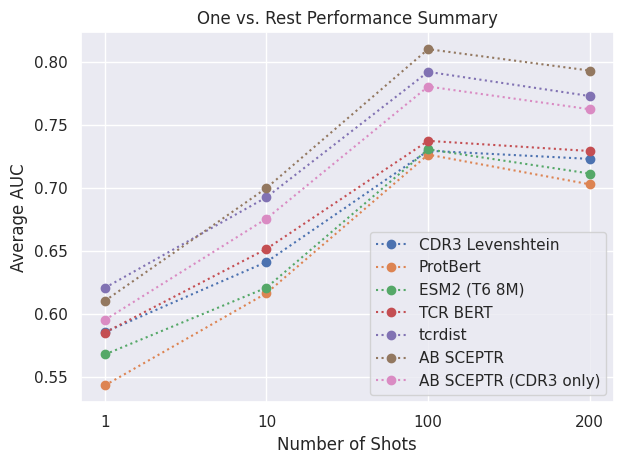

In [10]:
fig = plot_ovr_nn_summary_figure(MODEL_NAMES)

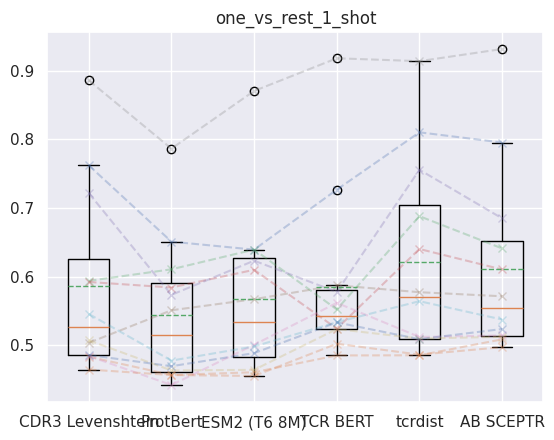

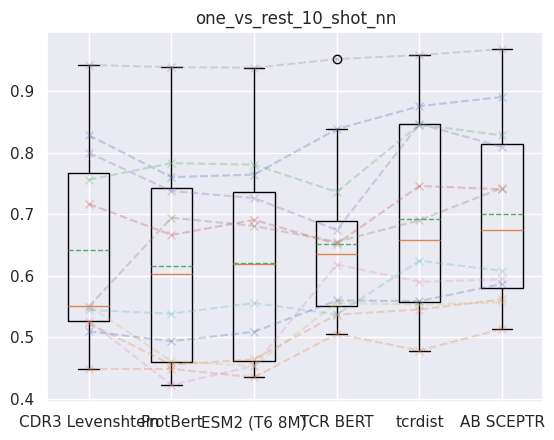

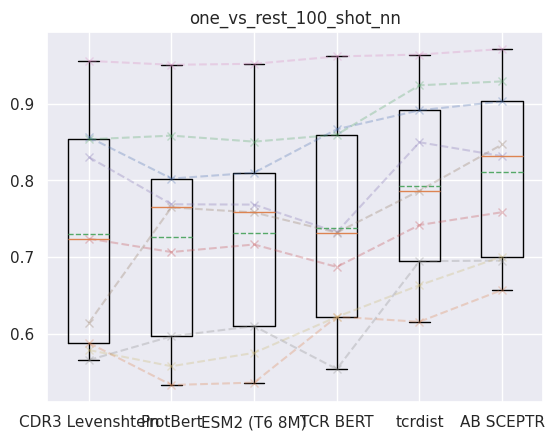

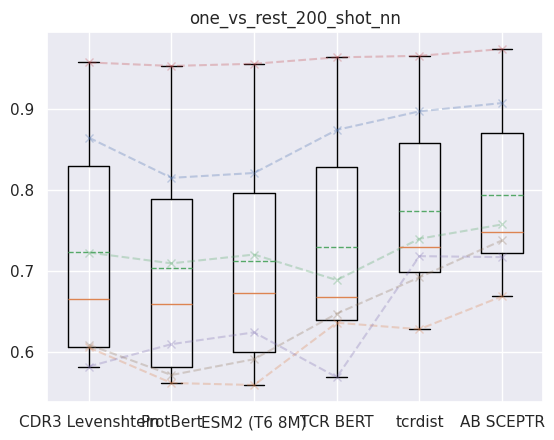

In [14]:
figs = {
    task_name: plot_auc_distributions(MODEL_NAMES, task_name) for task_name in TASKS
}